In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from collections import OrderedDict
import torch.optim as optim

In [2]:
%ls

MNIST/                  ModelPrototyping.ipynb  ModelTrain-SRGAN.ipynb


In [12]:
import os
import cv2
lr_image_path = os.path.join("../data/raw/low")

lr_images = []

for image in os.listdir(lr_image_path):
    image = cv2.imread(os.path.join(lr_image_path, image), cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = cv2.resize(image, (64, 64))
        lr_images.append(image)
    else:
        pass

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


In [13]:
len(lr_images)

196

In [16]:
images = np.array(lr_images)
images = images.reshape(-1, 1, 64, 64)

In [17]:
images.shape

(196, 1, 64, 64)

In [18]:
images = images.astype(np.float32) / 255.0
dataloader = DataLoader(
    dataset=list(images), batch_size=32, shuffle=True)

In [19]:
# Total number of data
total_dataset = 0
for data in dataloader:
    total_dataset+=data.shape[0]
    
print("Total data # {} ".format(total_dataset))
print("The shape of the data # {}".format(data.shape))

Total data # 196 
The shape of the data # torch.Size([4, 1, 64, 64])


In [2]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import MNIST

# Define the transformation
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# Load the full MNIST dataset
full_dataset = MNIST(root=".", train=True, download=True, transform=transform)

# Create a subset with the first 1000 samples
subset_indices = range(500)
subset_dataset = Subset(full_dataset, subset_indices)

# Create a DataLoader for the subset
batch_size = 64
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

# Now you can use subset_dataloader to iterate over the subset of 1000 samples

0.3%

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100.0%
45.7%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100.0%
100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
for data, label in dataloader:
    print(data.shape, label)
    break

torch.Size([64, 1, 64, 64]) tensor([2, 3, 3, 0, 6, 0, 9, 1, 6, 2, 8, 9, 2, 2, 3, 6, 5, 3, 6, 1, 1, 4, 2, 9,
        5, 4, 2, 0, 6, 2, 1, 7, 9, 1, 9, 5, 1, 8, 4, 8, 9, 9, 6, 5, 9, 1, 4, 8,
        9, 9, 1, 1, 3, 3, 9, 0, 8, 5, 3, 4, 0, 0, 0, 3])


In [4]:
# Check the quantity of the dataset
total_data = 0

for image, label in dataloader:
    total_data += image.shape[0]

print("total quantity of the dataset # {} ".format(total_data))
print("The shape of the data # {} ".format(image.shape))

total quantity of the dataset # 500 
The shape of the data # torch.Size([52, 1, 64, 64]) 


In [20]:
import torch.nn as nn


class ResidualBlock(nn.Module):
    """
    A residual block for the Generator network.

    Parameters
    ----------
    in_channels : int
        Number of input channels.

    Methods
    -------
    forward(x)
        Performs a forward pass through the residual block.

    Examples
    --------
    # Create a residual block
    residual_block = ResidualBlock(in_channels=64)

    # Perform forward pass
    output = residual_block(input_tensor)
    """

    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
        )

    def forward(self, x):
        """
        Perform a forward pass through the residual block.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after the residual block.
        """
        return x + self.block(x)


class UpSample(nn.Module):
    """
    An up-sampling module for the Generator network.

    Methods
    -------
    forward(x)
        Performs a forward pass through the up-sampling module.

    Examples
    --------
    # Create an up-sampling module
    upsample_module = UpSample()

    # Perform forward pass
    output = upsample_module(input_tensor)
    """

    def __init__(self):
        super(UpSample, self).__init__()
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.PReLU(),
        )

    def forward(self, x):
        """
        Perform a forward pass through the up-sampling module.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after up-sampling.
        """
        return self.upsample(x)


class Generator(nn.Module):
    """
    The Generator network for image super-resolution.

    Parameters
    ----------
    in_channels : int, optional
        Number of input channels. Default is 1.
    num_residual_blocks : int, optional
        Number of residual blocks in the network. Default is 16.

    Methods
    -------
    forward(x)
        Performs a forward pass through the generator network.

    Examples
    --------
    # Create a generator
    generator = Generator(in_channels=1, num_residual_blocks=16)

    # Perform forward pass
    output_image = generator(input_image)
    """

    def __init__(self, in_channels=1, num_residual_blocks=16):
        super(Generator, self).__init__()

        # Initial Convolutional Layer
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU()
        )

        # Residual Blocks
        self.residuals = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )

        # Up-Sampling Module
        self.upsample = nn.Sequential(*[UpSample() for _ in range(2)])

        # Final Convolutional Layer
        self.final = nn.Sequential(
            nn.Conv2d(64, in_channels, kernel_size=9, stride=1, padding=4), nn.Tanh()
        )

    def forward(self, x):
        """
        Perform a forward pass through the generator network.

        Parameters
        ----------
        x : torch.Tensor
            Input image tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after super-resolution.
        """
        initial = self.initial(x)
        residuals = self.residuals(initial)
        x = initial + residuals
        x = self.upsample(x)
        x = self.final(x)
        return x

In [21]:
if __name__ == "__main__":
    generator = Generator()

In [7]:
# Find out the total trainable parameters
total_params = 0
for params in generator.parameters():
    total_params+=params.numel()
    
print("Total # of trainable parameters # {}".format(total_params))

Total # of trainable parameters # 1491668


In [8]:
# Check it works or not
noise_data = torch.randn(64, 1, 64, 64)
generator(noise_data).shape

torch.Size([64, 1, 256, 256])

In [22]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.nf = 64
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, self.nf, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.nf, self.nf, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.nf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.nf, self.nf * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.nf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.nf * 2, self.nf * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.nf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.nf * 2, self.nf * 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.nf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.nf * 4, self.nf * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.nf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.nf * 4, self.nf * 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.nf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.nf * 8, self.nf * 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.nf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.nf * 8, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1),
        )

    def forward(self, x):
        x = self.main(x)
        return torch.sigmoid(x.view(x.size(0), -1))

In [23]:
if __name__ == '__main__':
    discriminator = Discriminator()
    

In [11]:
noise_data = torch.randn(64, 1, 64, 64)
discriminator(noise_data).shape

torch.Size([64, 1])

In [12]:
# Total trainable params
total_params = 0
for params in discriminator.parameters():
    total_params+=params.numel()
    
print("Total trainable params # {} ".format(total_params))

Total trainable params # 5214273 


In [24]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [25]:
generator = Generator()
discriminator = Discriminator()

loss_function = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [28]:
num_epochs = 50
for epoch in range(num_epochs):
    D_loss = list()
    G_loss = list()
    for i, imgs in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False)

        # Configure input
        real_imgs = imgs

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_generator.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss = loss_function(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_generator.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_discriminator.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = loss_function(discriminator(real_imgs), valid)
        fake_loss = loss_function(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_discriminator.step()
        
        G_loss.append(g_loss.item())
        D_loss.append(d_loss.item())

        if i%400:
            print(
                f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
            )
    print("Completed...")
    print("G_loss: {} - D_loss: {} ".format(np.array(G_loss).mean(), np.array(D_loss).mean()))
    

[Epoch 0/50] [Batch 1/7] [D loss: 0.6847860813140869] [G loss: 0.7731496095657349]
[Epoch 0/50] [Batch 2/7] [D loss: 0.6479179859161377] [G loss: 0.704969584941864]
[Epoch 0/50] [Batch 3/7] [D loss: 0.6119234561920166] [G loss: 0.7374585866928101]
[Epoch 0/50] [Batch 4/7] [D loss: 0.5698306560516357] [G loss: 0.8522102236747742]
[Epoch 0/50] [Batch 5/7] [D loss: 0.5834105014801025] [G loss: 0.8178445100784302]
[Epoch 0/50] [Batch 6/7] [D loss: 0.5931556820869446] [G loss: 0.853084921836853]
Completed...
G_loss: 0.7721910221236092 - D_loss: 0.6264966130256653 
[Epoch 1/50] [Batch 1/7] [D loss: 0.5588186979293823] [G loss: 0.8599433898925781]
[Epoch 1/50] [Batch 2/7] [D loss: 0.5138226747512817] [G loss: 0.8117914795875549]
[Epoch 1/50] [Batch 3/7] [D loss: 0.46606266498565674] [G loss: 1.135252594947815]
[Epoch 1/50] [Batch 4/7] [D loss: 0.4485991597175598] [G loss: 1.0990628004074097]
[Epoch 1/50] [Batch 5/7] [D loss: 0.39635443687438965] [G loss: 1.174264907836914]
[Epoch 1/50] [Batch

In [34]:
data = next(iter(dataloader))
dataset = data[0:20]
dataset.shape

torch.Size([20, 1, 64, 64])

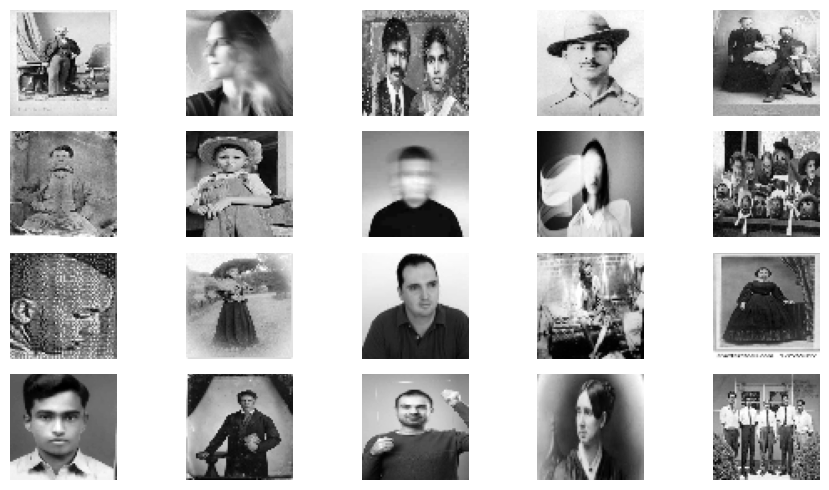

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for index, image in enumerate(dataset):
    plt.subplot(4, 5, index + 1)
    plt.imshow(image.detach().numpy().reshape(64, 64), cmap="gray")
    plt.axis("off")
    plt.tight_layout()

plt.show()

In [36]:
generated_data.shape

torch.Size([20, 1, 256, 256])

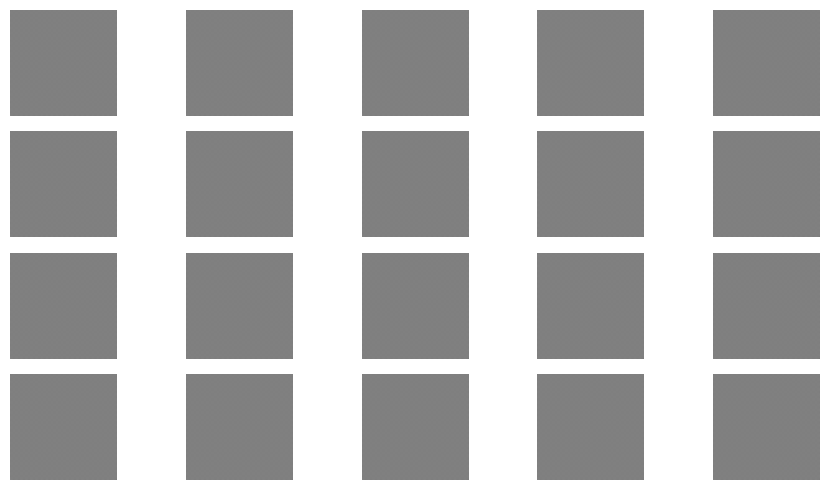

In [47]:
# generated_data = generator(dataset)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))

# for index, image in enumerate(generated_data):
#     plt.subplot(4, 5, index + 1)
#     plt.imshow(image.detach().numpy().reshape(256, 256), cmap="gray_r")
#     plt.axis('off')
#     plt.tight_layout()
        
# plt.show()
    